# Data Visualize and ML with Python

In this tutorial, we will learn how to read tif, shp file with python, and training a model.  
Before we start, we should install packages.

In [ ]:
# check the package we need had been installed
%pip install matplotlib geopandas rasterio lightgbm scikit-learn

## 1. Get Data

- Download demo data from [here](https://thinktronltdcorp-my.sharepoint.com/:u:/g/personal/willie_wu_thinktronltd_com/ES_p-ukAhdlIrFmC1vcBdgkBmJXqIncips4Bg3tGuPudtQ?e=YGfWkK)
- Upload demo_data.zip to colab

In [1]:
from zipfile import ZipFile

with ZipFile('demo_data.zip', 'r') as zf:
    zf.extractall('demo_data')

## 2. Read Sentinel-2 Image

- The Image we download from [Open Access Hub](https://scihub.copernicus.eu/) is a zip file with bands we selected.  
- Use package **rasterio** and **numpy** to read and process tif file.
- Use package **matplotlib** to plot image.

### 2.1 Read tif
> rasterio: https://rasterio.readthedocs.io/en/stable/

In [2]:
import rasterio as rio

rst = rio.open('demo_data/sentinel-2/2023-01-25/Sentinel-2_L2A_True_color.tiff')

# loop tif's metadata
for k, v in rst.profile.items():
    print(f'{k}:\n{v}\n-------------')

driver:
GTiff
-------------
dtype:
uint8
-------------
nodata:
None
-------------
width:
2500
-------------
height:
1610
-------------
count:
3
-------------
crs:
EPSG:4326
-------------
transform:
| 0.00, 0.00, 120.01|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|
-------------
blockxsize:
2500
-------------
blockysize:
8
-------------
tiled:
False
-------------
compress:
deflate
-------------
interleave:
pixel
-------------


### 2.2 Plot the tif
> matplotlib: https://matplotlib.org/stable/tutorials/index.html

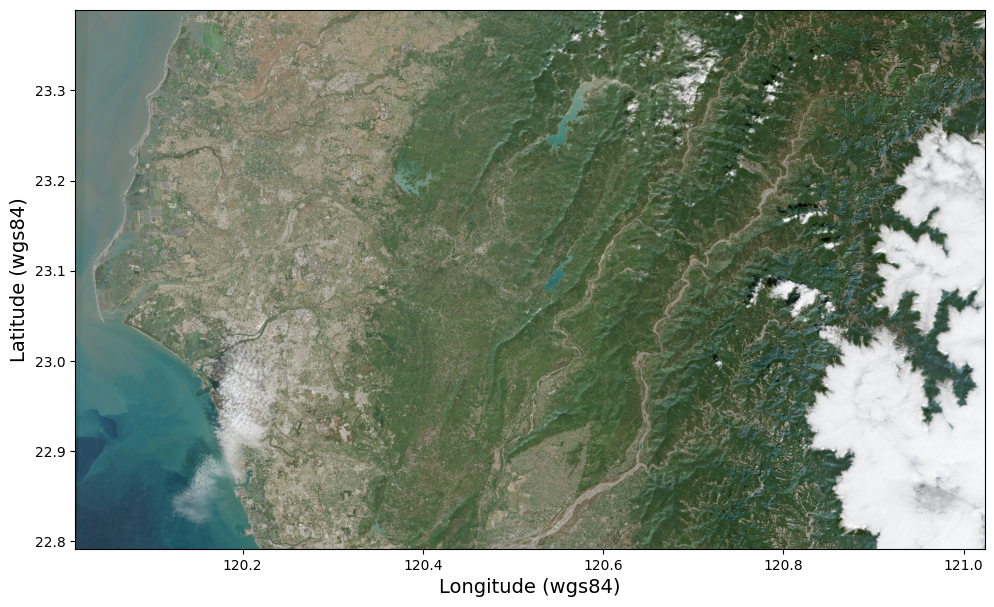

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
arr = rst.read() # the shape is band, height, width
left, bottom, right, top = rst.bounds # get sentinel-2's bound
plt.imshow(arr.transpose([1,2,0]), extent=[left, right, bottom, top])
plt.xlabel('Longitude (wgs84)', fontsize=14)
plt.ylabel('Latitude (wgs84)', fontsize=14)
plt.show()

### 2.3 Process SCL image
> Ref: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

- Scene classification (SCL) was developed to distinguish between cloudy pixels, clear pixels and water pixels of Sentinel-2 data and is a result of the Scene classification algorithm run by ESA.  
- 12 different classifications are provided including classes of clouds, vegetation, soils/desert, water and snow.  
- It does not constitute a land cover classification map in a strict sense.

![image.png](docs/pic/SCL.png)

#### 2.3.1 Define SCL class color

In [4]:
scl_classes = {
  0: [0, 0, 0],        # No Data (Missing data) - black  
  1: [255, 0, 0],      # Saturated or defective pixel - red 
  2: [47, 47, 47],     # Topographic casted shadows ("Dark features/Shadows" for data before 2022-01-25) - very dark grey
  3: [100, 50, 0],     # Cloud shadows - dark brown
  4: [0, 160, 0],      # Vegetation - green
  5: [255, 230, 90],   # Not-vegetated - dark yellow
  6: [0, 0, 255],      # Water (dark and bright) - blue
  7: [128, 128, 128],  # Unclassified - dark grey
  8: [192, 192, 192],  # Cloud medium probability - grey
  9: [255, 255, 255],  # Cloud high probability - white
  10: [100, 200, 255], # Thin cirrus - very bright blue
  11: [255, 150, 255], # Snow or ice - very bright pink
}

#### 2.3.2 Convert SCL image with rgb bands to single band
> numpy: https://numpy.org/doc/stable/index.html

In [5]:
import numpy as np

# read tif
rst_scl = rio.open('demo_data/sentinel-2/2023-01-25/Sentinel-2_L2A_Scene_classification_map_.tiff')
arr_scl_rgb = rst_scl.read().astype(float)

# create empty array with the same shape of tif
arr_scl = np.empty(rst_scl.shape)

# assign new value to the empty array
for value, (r, g, b) in scl_classes.items():
    condition = np.where(
        (abs(arr_scl_rgb[0] - r) <= 1) & 
        (abs(arr_scl_rgb[1] - g) <= 1) & 
        (abs(arr_scl_rgb[2] - b) <= 1)
    )
    arr_scl[condition] = value

#### 2.3.3 Plot result with custom colormap

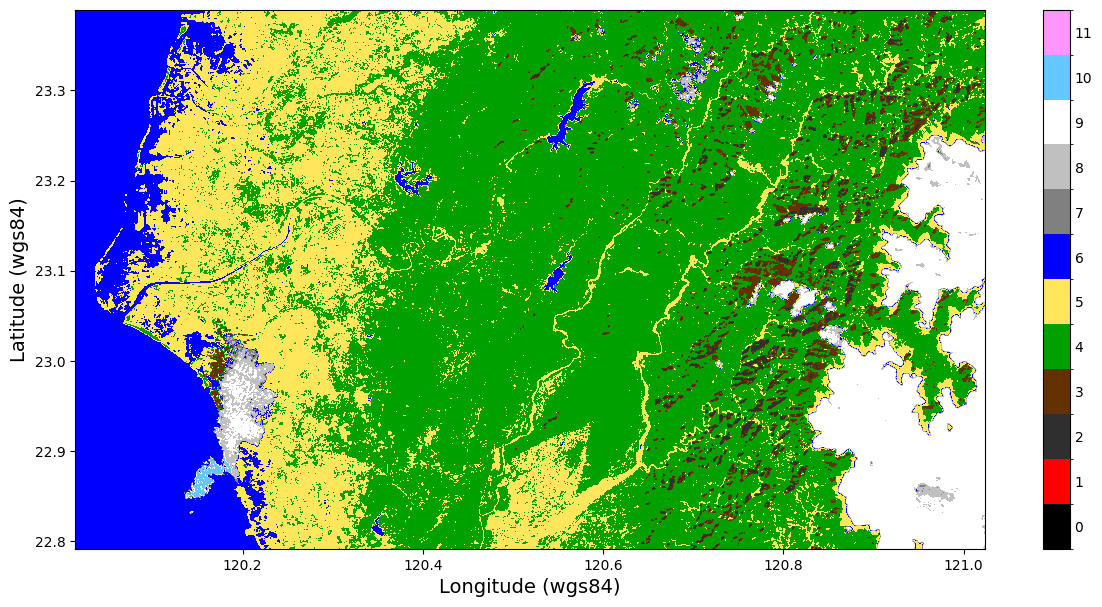

In [6]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# define colormap
scl_map = ListedColormap([(r/255, g/255, b/255) for (r,g,b) in scl_classes.values()])
bounds = [i-0.5 for i in scl_classes.keys()] + [11.5]
norm = BoundaryNorm(bounds, scl_map.N)

# plot
fig = plt.figure(figsize=(15, 7))
left, bottom, right, top = rst_scl.bounds
im_scl = plt.imshow(arr_scl, extent=[left, right, bottom, top], cmap=scl_map, norm=norm)
cbar = fig.colorbar(im_scl)
cbar.set_ticks([i for i in scl_classes.keys()], labels=[str(i) for i in scl_classes.keys()])
cbar.ax.tick_params(length=0)
plt.xlabel('Longitude (wgs84)', fontsize=14)
plt.ylabel('Latitude (wgs84)', fontsize=14)
plt.show()

## 3. Read Shapefile
- The Shapefile contains marianland's area.
- Use package **geopandas** to access shp file.

### 3.1 Read shp
> geopandas: https://geopandas.org/en/stable/

In [7]:
import geopandas as gpd

gdf = gpd.read_file('demo_data/shapefile/label.shp')
gdf

,FID,geometry
0,0,"POLYGON ((120.375 22.88649, 120.3751 22.88647,..."
1,1,"POLYGON ((120.37506 22.88728, 120.3751 22.8875..."
2,2,"POLYGON ((120.37752 22.88846, 120.37739 22.888..."
3,3,"POLYGON ((120.38354 22.87697, 120.38375 22.877..."
4,4,"POLYGON ((120.38442 22.87725, 120.38435 22.877..."
...,...,...
13006,13006,"POLYGON ((120.55731 22.76399, 120.55707 22.763..."
13007,13007,"POLYGON ((120.55496 22.7637, 120.55573 22.7643..."
13008,13008,"POLYGON ((120.5775 22.76528, 120.57819 22.7649..."
13009,13009,"POLYGON ((120.55059 22.75678, 120.55209 22.756..."


### 3.2 Plot shp

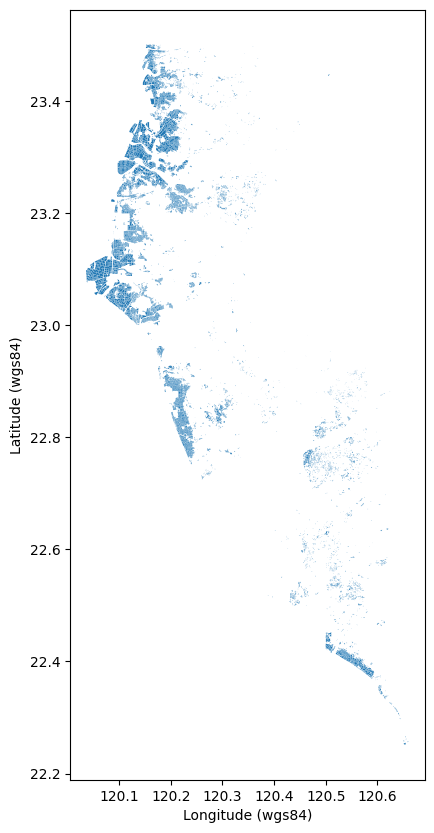

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
gdf.plot(ax=ax)
ax.set_xlabel('Longitude (wgs84)')
ax.set_ylabel('Latitude (wgs84)')
plt.show()

## 4. Fusion Tiff Image and Shp

### 4.1 Plot overlap

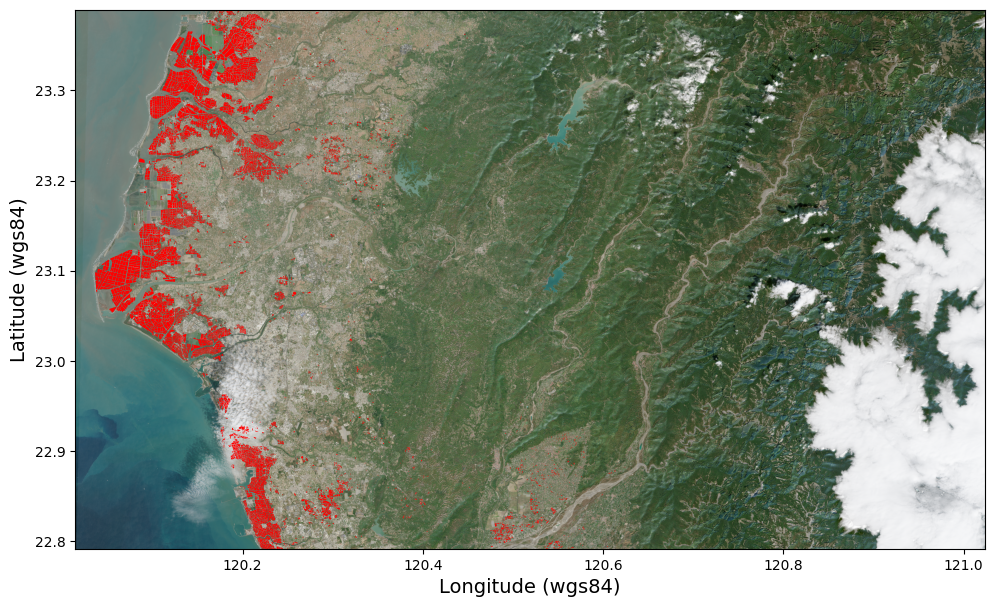

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# convert to the same epsg
gdf.to_crs(rst.crs.to_epsg()).plot(ax=ax, color='red')
left, bottom, right, top = rst.bounds
plt.imshow(arr.transpose([1,2,0]), extent=[left, right, bottom, top])
plt.xlabel('Longitude (wgs84)', fontsize=14)
plt.ylabel('Latitude (wgs84)', fontsize=14)
plt.show()

### 4.2 Clip tif by shp

#### 4.2.1 Clip

In [10]:
import rasterio.mask as rmask

masked_arr, gt = rmask.mask(rst, gdf.to_crs(rst.crs.to_epsg())['geometry'].values, all_touched=True)

#### 4.2.2 Plot result

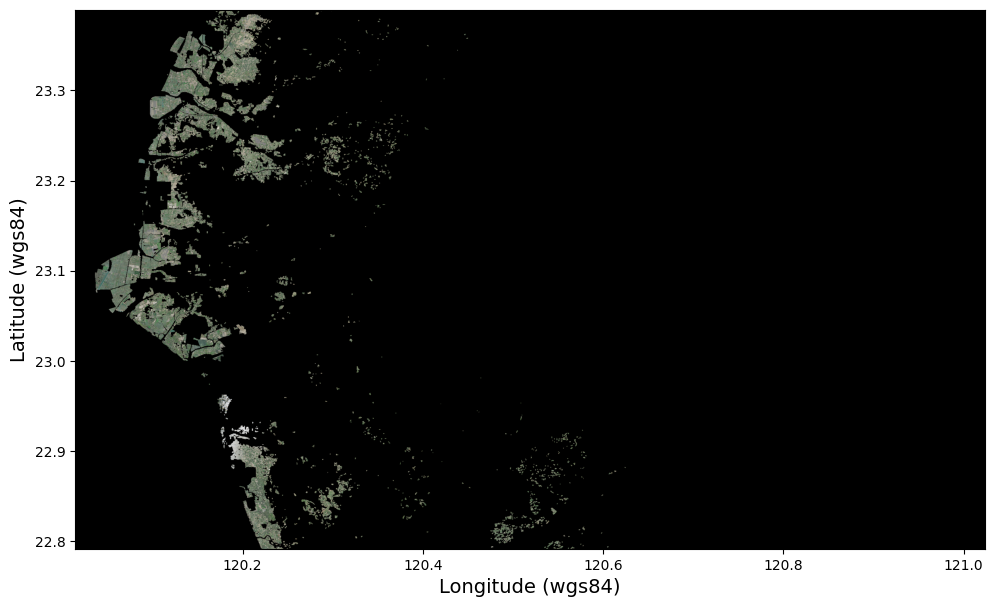

In [11]:
fig = plt.figure(figsize=(15, 7))
plt.imshow(masked_arr.transpose([1,2,0]), extent=[left, right, bottom, top])
plt.xlabel('Longitude (wgs84)', fontsize=14)
plt.ylabel('Latitude (wgs84)', fontsize=14)
plt.show()

## 5. Prepare Data for ML

In [12]:
from pathlib import Path
from datetime import datetime

### 5.1 Merge necessary bands and save as tif
- **B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12** (bands from zip)
- **SCL** (processing from scene_classification_map)
- **ROWS, COLS** (calculate pixel index in array)

In [13]:
bands =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'classification']

def merge_bands(tif_folder: Path, output_tif_fp: Path):
    dict_img = dict()
        
    # glob all file in folder
    for tif_fp in tif_folder.glob('*.tiff'):
            
        # extract necessory band
        for band in bands:
            if band not in tif_fp.stem:
                continue
            dict_img[band] = rio.open(tif_fp)
    
    # read array
    tif_data = []
    for band in bands[:-1]:
        tif_data.append(dict_img[band].read())

    # convert scl array from 3 bands to 1 band
    rst_scl = dict_img['classification']
    arr_scl_rgb = rst_scl.read().astype(float)
    
    # create empty array with the same shape of tif
    h, w = rst_scl.shape
    arr_scl = np.empty((h, w))

    # assign new value to the empty array
    for value, (r, g, b) in scl_classes.items():
        condition = np.where(
            (abs(arr_scl_rgb[0] - r) <= 1) & 
            (abs(arr_scl_rgb[1] - g) <= 1) & 
            (abs(arr_scl_rgb[2] - b) <= 1)
        )
        arr_scl[condition] = value
    tif_data.append(arr_scl.reshape(1, h, w))

    # add row index and col index
    row_vals, col_vals = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    arr_row_col = np.stack((row_vals, col_vals), axis=-1).transpose([2,0,1])
    tif_data.append(arr_row_col)
    tif_arr = np.concatenate(tif_data)

    # write tif metadata
    profile = rst_scl.profile
    profile.update(
        dict(
            count=tif_arr.shape[0],
            compress='lzw',
            dtype=rio.uint16,
        )
    )

    # export tif
    with rio.open(output_tif_fp, 'w', **profile) as dst:
        dst.write(tif_arr)
        dst.descriptions = tuple(bands[:-1] + ['SCL', 'ROWS', 'COLS'])

In [14]:
sentinel2_folder = Path('demo_data/sentinel-2/')

# create folder to save tif file
Path('demo_data/tif').mkdir(exist_ok=True)

# use  to get tif_folder
for tif_folder in sentinel2_folder.iterdir():
    t = datetime.fromisoformat(f'{tif_folder.stem}T00:00:00+00:00')
    merge_bands(tif_folder, Path(f'demo_data/tif/{t:%Y-%m-%d}.tif'))
    print(f'Merge {t} done.')
print('All finished')

Merge 2023-01-25 00:00:00+00:00 done.
Merge 2024-02-14 00:00:00+00:00 done.
All finished


### 5.2 Convert 2023's tif into training data
> pandas: https://pandas.pydata.org/

#### 5.2.1 Do normalization

Clip min and max value and normalized to 0 ~ 1.

In [15]:
def norm(arr, clip=[0.01,0.99]):
    arr_copy = arr.copy()
    tmp = np.sort(arr_copy.flatten())
    tmp = tmp[tmp >= 0]
    
    new_min = tmp[int(len(tmp)*clip[0])]
    if clip[1] >= 1:
        new_max = tmp[-1]
    else:
        new_max = tmp[int(len(tmp)*clip[1])]

    arr_copy[arr_copy < new_min] = new_min
    arr_copy[arr_copy > new_max] = new_max
    
    return (arr_copy - np.nanmin(arr_copy)) / (np.nanmax(arr_copy) - np.nanmin(arr_copy))

### 5.2.2 Find label

- True: The pixel that overlap label shp and the SCL is not cloud or none (0, 3, 8, 9).
- False: Other pixel

In [16]:
def filter_with_cloud_and_label(rst: rio.io.DatasetReader, gdf_label: gpd.GeoDataFrame):
    """
    return mask contain cloud and not label
    """
    bands = list(rst.descriptions)
    scl_idx = bands.index('SCL')

    masked_arr, gt = rmask.mask(rst, gdf_label.to_crs(rst.crs.to_epsg())['geometry'].values, all_touched=True)
    return (masked_arr[scl_idx] == 0) | (masked_arr[scl_idx] == 3) | (masked_arr[scl_idx] == 8) | (masked_arr[scl_idx] == 9)  

In [17]:
import pandas as pd

tmp = []
gdf = gpd.read_file('demo_data/shapefile/label.shp')

for tif_fp in Path('demo_data/tif').glob('2023*.tif'):
    rst = rio.open(tif_fp)
    h, w = rst.shape
    bands_num = rst.count
    arr = rst.read()
    
    # convert array to dataframe
    df = pd.DataFrame(arr.reshape([bands_num, h*w]).T, columns=rst.descriptions, dtype=float)

    # normalize b01 ~ b12's data
    df.iloc[:,:12] = norm(arr[:12]).reshape([12, h*w]).T

    # calculate mask and add to label
    arr_mask = filter_with_cloud_and_label(rst, gdf)
    df['label'] = ~arr_mask.reshape(h*w)

    # note value source
    df['frame'] = tif_fp.stem
    tmp.append(df)
    print(f'convert {tif_fp.stem} done.')

df = pd.concat(tmp).reset_index(drop=True)
df

convert 2023-01-25 done.


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS,label,frame
0,0.069959,0.074074,0.082305,0.061728,0.053498,0.024691,0.024691,0.024691,0.020576,0.004115,0.008230,0.004115,6.0,0.0,0.0,False,2023-01-25
1,0.069959,0.069959,0.078189,0.057613,0.053498,0.024691,0.024691,0.020576,0.020576,0.004115,0.008230,0.004115,6.0,0.0,1.0,False,2023-01-25
2,0.069959,0.074074,0.082305,0.061728,0.053498,0.024691,0.024691,0.024691,0.016461,0.004115,0.004115,0.004115,6.0,0.0,2.0,False,2023-01-25
3,0.069959,0.069959,0.078189,0.057613,0.053498,0.024691,0.024691,0.020576,0.020576,0.004115,0.004115,0.004115,6.0,0.0,3.0,False,2023-01-25
4,0.069959,0.074074,0.082305,0.065844,0.057613,0.028807,0.024691,0.028807,0.020576,0.004115,0.008230,0.004115,6.0,0.0,4.0,False,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024995,0.399177,0.423868,0.390947,0.353909,0.382716,0.444444,0.469136,0.522634,0.469136,0.736626,0.362140,0.308642,9.0,1609.0,2495.0,False,2023-01-25
4024996,0.366255,0.366255,0.329218,0.292181,0.325103,0.399177,0.432099,0.473251,0.436214,0.687243,0.320988,0.279835,9.0,1609.0,2496.0,False,2023-01-25
4024997,0.337449,0.304527,0.283951,0.263374,0.300412,0.386831,0.419753,0.432099,0.432099,0.646091,0.300412,0.271605,9.0,1609.0,2497.0,False,2023-01-25
4024998,0.308642,0.275720,0.263374,0.242798,0.283951,0.370370,0.407407,0.427984,0.415638,0.604938,0.292181,0.259259,8.0,1609.0,2498.0,False,2023-01-25


In [18]:
df_true = df[df['label'] == True]
df_false = df[(df['label'] == False)&(df['SCL']!=0)&(df['SCL']!=3)&(df['SCL']!=8)&(df['SCL']!=9)]
print(f'before_balance, true = {len(df_true)}, false = {len(df_false)}')

df_datasets = pd.concat([df_true, df_false.sample(len(df_true))]).reset_index(drop=True)
df_datasets

before_balance, true = 167208, false = 3425072


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS,label,frame
0,0.061728,0.053498,0.069959,0.086420,0.123457,0.164609,0.181070,0.189300,0.209877,0.172840,0.222222,0.156379,5.0,0.0,377.0,True,2023-01-25
1,0.049383,0.049383,0.061728,0.074074,0.115226,0.168724,0.193416,0.209877,0.226337,0.176955,0.205761,0.127572,5.0,0.0,378.0,True,2023-01-25
2,0.049383,0.045267,0.061728,0.065844,0.102881,0.185185,0.205761,0.234568,0.234568,0.201646,0.176955,0.111111,5.0,0.0,379.0,True,2023-01-25
3,0.049383,0.049383,0.065844,0.069959,0.102881,0.164609,0.185185,0.209877,0.213992,0.193416,0.181070,0.115226,5.0,0.0,380.0,True,2023-01-25
4,0.045267,0.041152,0.057613,0.065844,0.086420,0.123457,0.139918,0.172840,0.160494,0.172840,0.156379,0.094650,5.0,0.0,381.0,True,2023-01-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334411,0.020576,0.000000,0.000000,0.000000,0.000000,0.012346,0.020576,0.004115,0.016461,0.189300,0.032922,0.012346,4.0,90.0,2079.0,False,2023-01-25
334412,0.008230,0.012346,0.028807,0.016461,0.057613,0.189300,0.238683,0.251029,0.275720,0.267490,0.148148,0.061728,4.0,31.0,1878.0,False,2023-01-25
334413,0.024691,0.016461,0.028807,0.020576,0.053498,0.148148,0.185185,0.205761,0.205761,0.238683,0.127572,0.061728,4.0,1533.0,1542.0,False,2023-01-25
334414,0.045267,0.037037,0.024691,0.012346,0.012346,0.008230,0.008230,0.008230,0.008230,0.000000,0.004115,0.000000,6.0,1600.0,62.0,False,2023-01-25


### 5.3 Split to train_set and valid_set
> Ref: https://lightgbm.readthedocs.io/en/stable/  
> Ref: https://scikit-learn.org/stable/

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df_datasets.iloc[:,0:12], 
    df_datasets.loc[:,'label'], 
    test_size=0.1, 
    random_state=2024, 
    shuffle=True
)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

## 6. Training

In [20]:
params = {
    "objective": "binary",
    "metric": ["binary_error","l1","l2"],
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Trees
    # 'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 1e-6,           # Learning rate
    'feature_fraction': 0.9,         # Randomly select a fraction of features for training each tree
}

callbacks = [
    lgb.log_evaluation(period=1), 
    # lgb.early_stopping(stopping_rounds=50)
]

In [21]:
bst = lgb.train(
    params, 
    train_data, 
    valid_sets=[train_data, val_data], 
    num_boost_round=10,
    callbacks=callbacks
)

[LightGBM] [Info] Number of positive: 150646, number of negative: 150328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2326
[LightGBM] [Info] Number of data points in the train set: 300974, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500528 -> initscore=0.002113
[LightGBM] [Info] Start training from score 0.002113
[1]	training's binary_error: 0.499472	training's l1: 0.499999	training's l2: 0.249999	valid_1's binary_error: 0.504755	valid_1's l1: 0.500005	valid_1's l2: 0.250005
[2]	training's binary_error: 0.499472	training's l1: 0.499999	training's l2: 0.249999	valid_1's binary_error: 0.504755	valid_1's l1: 0.500004	valid_1's l2: 0.250005
[3]	training's binary_error: 0.499472	training's l1: 0.499998	training's l2: 0.249999	valid_1's binary_error: 0

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

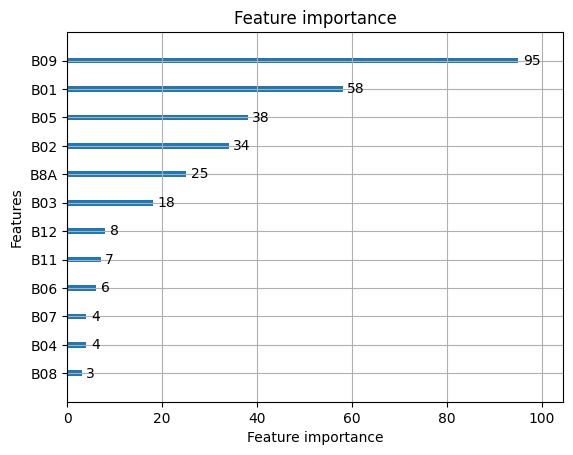

In [22]:
lgb.plot_importance(bst, max_num_features=12)

If you want to save the model you trained, you could run the script to save it.
```python
>>> bst.save_model('model.txt')
```

## 7. Predict

### 7.1 Predict with model

In [23]:
model = lgb.Booster(model_file='demo_data/weights/model.txt')
prob = model.predict(X_val)
res = np.where(prob>=0.5,1,0)
df_predict = pd.DataFrame(np.array([prob, res, y_val]).T, columns=['prob', 'predict', 'label'])
df_predict

,prob,predict,label
0,0.499549,0.0,0.0
1,0.499528,0.0,0.0
2,0.499528,0.0,0.0
3,0.499528,0.0,0.0
4,0.499842,0.0,1.0
...,...,...,...
33437,0.500451,1.0,1.0
33438,0.500434,1.0,0.0
33439,0.499539,0.0,0.0
33440,0.500307,1.0,0.0


### 7.2 Analysis result

In [24]:
TP = len(df_predict[(df_predict['predict'] == 1) & (df_predict['label'] == 1)])
TN = len(df_predict[(df_predict['predict'] == 0) & (df_predict['label'] == 0)])
FP = len(df_predict[(df_predict['predict'] == 1) & (df_predict['label'] == 0)])
FN = len(df_predict[(df_predict['predict'] == 0) & (df_predict['label'] == 1)])
Total = len(df_predict)

print(f'TP = {TP/Total*100:.2f}%\nTN = {TN/Total*100:.2f}%\nFP = {FP/Total*100:.2f}%\nFN = {FN/Total*100:.2f}%\nAcc = {(TP+TN)/Total*100:.2f}%')

TP = 46.79%
TN = 37.78%
FP = 12.70%
FN = 2.74%
Acc = 84.56%


### 7.3 Predict entire image

### 7.3.1 Convert tif to dataframe

In [25]:
rst = rio.open('demo_data/tif/2024-02-14.tif')
h, w = rst.shape
bands_num = rst.count
arr = rst.read()
df = pd.DataFrame(arr.reshape([bands_num, h*w]).T, columns=rst.descriptions, dtype=float)
df.iloc[:,:12] = norm(arr[:12]).reshape([12, h*w]).T
df

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,SCL,ROWS,COLS
0,0.084906,0.103774,0.094340,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,0.0
1,0.084906,0.103774,0.084906,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,1.0
2,0.084906,0.103774,0.084906,0.028302,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,2.0
3,0.084906,0.103774,0.094340,0.028302,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,3.0
4,0.084906,0.103774,0.084906,0.018868,0.018868,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024995,0.301887,0.254717,0.301887,0.273585,0.396226,0.726415,0.867925,0.877358,0.943396,0.95283,0.613208,0.481132,4.0,1609.0,2495.0
4024996,0.377358,0.330189,0.386792,0.386792,0.500000,0.839623,0.981132,0.990566,1.000000,1.00000,0.735849,0.632075,4.0,1609.0,2496.0
4024997,0.452830,0.415094,0.462264,0.462264,0.575472,0.896226,1.000000,1.000000,1.000000,1.00000,0.820755,0.707547,5.0,1609.0,2497.0
4024998,0.528302,0.481132,0.518868,0.509434,0.622642,0.952830,1.000000,1.000000,1.000000,1.00000,0.886792,0.783019,5.0,1609.0,2498.0


### 7.3.2 Predict

In [26]:
p = model.predict(df.iloc[:,:12])
res = np.where(p>=0.5, 1, 0)

### 7.3.3 Plot result

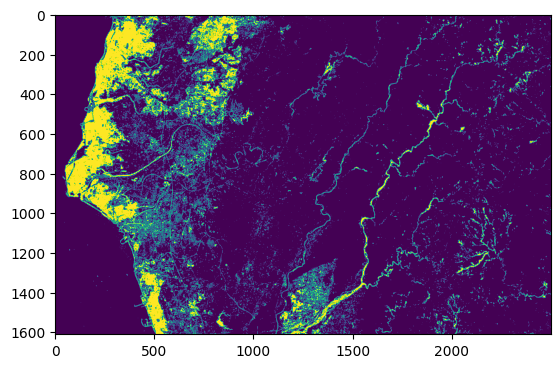

In [27]:
import matplotlib.pyplot as plt

plt.imshow(res.reshape([h, w]))